# _**02.Electromagnetic sources**_

### _**Importacion de librerias necesarias**_

In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

### _**Función de visualización**_

In [15]:
def visualize_simulation(sim, cell_size, pml_thickness, source_position, 
                         max_time, frame_interval, output_filename='animation.mp4'):
    """
    Visualiza una simulación de Meep con animación 2D
    
    Parámetros:
    sim: Objeto de simulación Meep
    cell_size: Tamaño de la celda de simulación
    pml_thickness: Grosor de las capas PML
    source_position: Posición de la fuente (Vector3)
    max_time: Tiempo máximo de simulación
    frame_interval: Intervalo entre frames capturados
    output_filename: Nombre del archivo de salida para la animación
    """
    
    # Capturar datos estáticos finales
    ez_data = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_size, cell_size, 0), component=mp.Ez)
    
    # Calcular posición de los bordes PML y fuente
    pml_boundary = cell_size/2 - pml_thickness
    source_x = source_position.x
    
    # Visualización estática
    plt.figure(figsize=(8, 7))
    plt.imshow(ez_data.transpose(), interpolation="spline36", cmap="RdBu", 
              extent=[-cell_size/2, cell_size/2, -cell_size/2, cell_size/2])
    
    # Añadir líneas de referencia
    plt.axvline(x=-pml_boundary, color='gray', linestyle='--', alpha=0.7, label='PML Interior')
    plt.axvline(x=pml_boundary, color='gray', linestyle='--', alpha=0.7)
    plt.axhline(y=-pml_boundary, color='gray', linestyle='--', alpha=0.7)
    plt.axhline(y=pml_boundary, color='gray', linestyle='--', alpha=0.7)
    plt.axvline(x=source_x, color='green', linestyle='-', alpha=0.5, label='Fuente')
    plt.legend(loc='upper right')
    plt.colorbar(label='Campo Eléctrico ($E_z$)')
    plt.title('Estado Estacionario (t = {:.1f})'.format(max_time))
    plt.xlabel('Posición X')
    plt.ylabel('Posición Y')
    plt.tight_layout()
    plt.show()
    
    # Preparar para animación
    print("\nPreparando para animación...")
    sim.reset_meep()
    
    frames = []
    times = []
    
    # Función para capturar frames
    def capture_frame(sim):
        ez_data = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_size, cell_size, 0), component=mp.Ez)
        frames.append(ez_data.transpose())  # Almacenar transposición para orientación correcta
        times.append(sim.meep_time())
        return
    
    # Ejecutar simulación para animación
    print(f"Capturando frames cada {frame_interval} unidades de tiempo...")
    start_time = time.time()
    sim.run(
        mp.at_every(frame_interval, capture_frame),
        until=max_time
    )
    print(f"Simulación completada en {time.time()-start_time:.1f}s")
    print(f"Frames capturados: {len(frames)}")
    
    if len(frames) == 0:
        print("Error: No se capturaron frames para la animación")
        return
    
    # Crear animación
    print("\nCreando animación...")
    
    # Calcular rango de color consistente
    all_data = np.concatenate([f.flatten() for f in frames])
    vmax = np.percentile(np.abs(all_data), 99.5) * 1.2
    vmin = -vmax
    
    # Configurar figura
    fig, ax = plt.subplots(figsize=(8, 7))
    extent = [-cell_size/2, cell_size/2, -cell_size/2, cell_size/2]
    
    # Mostrar primer frame
    im = ax.imshow(frames[0], cmap='RdBu', vmin=vmin, vmax=vmax,
                   extent=extent, animated=True, aspect='equal')
    
    # Añadir barra de color
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Campo Eléctrico ($E_z$)', fontsize=12)
    
    # Marcar regiones importantes
    ax.axvline(x=-pml_boundary, color='gray', linestyle='--', alpha=0.7, label='PML Interior')
    ax.axvline(x=pml_boundary, color='gray', linestyle='--', alpha=0.7)
    ax.axhline(y=-pml_boundary, color='gray', linestyle='--', alpha=0.7)
    ax.axhline(y=pml_boundary, color='gray', linestyle='--', alpha=0.7)
    
    # Marcar posición de la fuente
    ax.axvline(x=source_x, color='green', linestyle='-', alpha=0.5, label='Fuente')
    
    # Configuración de título y etiquetas
    ax.set_title(f'Onda Plana (t = {times[0]:.1f})', fontsize=14)
    ax.set_xlabel('Posición X', fontsize=12)
    ax.set_ylabel('Posición Y', fontsize=12)
    ax.legend(loc='upper right')
    
    # Función de actualización para la animación
    def update(frame):
        im.set_array(frames[frame])
        ax.set_title(f'Onda Plana (t = {times[frame]:.1f})', fontsize=14)
        return im,
    
    # Crear animación
    anim = FuncAnimation(
        fig, 
        update, 
        frames=len(frames),
        interval=150,  # Tiempo entre frames en ms
        blit=True
    )
    
    plt.close(fig)  # Cerrar figura para ahorrar memoria
    
    # Guardar animación
    print(f"Guardando animación como '{output_filename}'...")
    anim.save(output_filename, writer='ffmpeg', fps=10, dpi=120, bitrate=1500)
    print("Animación guardada con éxito!")
    
    # Mostrar video en el notebook
    from IPython.display import Video
    print("\nMostrando animación en notebook...")
    return Video(output_filename)



### _**Parámetros de simulación**_

In [47]:
cell_size = 12 
pml_thickness = 1.0 
pml_layers=[mp.PML(pml_thickness)]
resolution = 30  
source_position = mp.Vector3(-cell_size/2 + pml_thickness + 1.0, 0)
source_frequency = 2.5
source_width = 1 
df = 0.5   # Ancho de banda
max_time = 20
frame_interval=0.5
waist = 1.0  # tamaño del haz en el foco
beam_x0 = 0.0  # posición del foco del haz en x
kdir = mp.Vector3(1, 0)    # dirección hacia +x
geometry=[]
default_material = mp.Medium(epsilon=1.0)

### _**Creación de celda y entorno de simulación**_

In [31]:
cell = mp.Vector3(cell_size, cell_size, 0)
sim = mp.Simulation(
    cell_size=cell,
    geometry=geometry,
    boundary_layers=pml_layers,
    default_material=default_material,
    resolution=resolution,
    dimensions=2
)

## _**Fuente Continua**_

In [32]:
cont_source = [
    mp.Source(
        mp.ContinuousSource(frequency=source_frequency, 
                          start_time=0, 
                          width=source_width),
        component=mp.Ez,
        center=source_position,
        size=mp.Vector3(0,0, 0)
    )
]
sim.reset_meep()
sim.sources = cont_source
sim.run(until=max_time)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000238895 s
Working in 2D dimensions.
Computational cell is 12 x 12 x 0 with resolution 30
time for set_epsilon = 0.149405 s
-----------
run 0 finished at t = 20.0 (1200 timesteps)


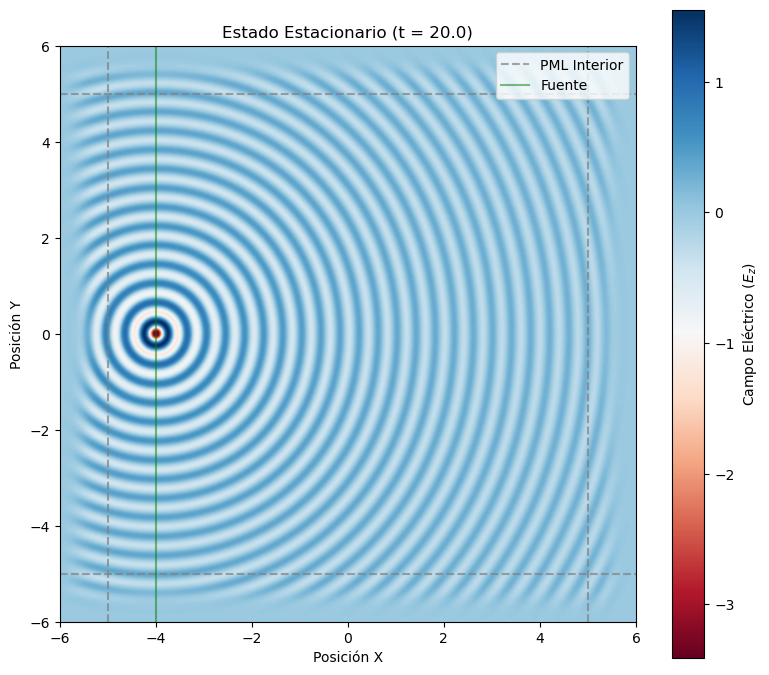


Preparando para animación...
Capturando frames cada 0.5 unidades de tiempo...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000231981 s
Working in 2D dimensions.
Computational cell is 12 x 12 x 0 with resolution 30
time for set_epsilon = 0.145357 s
-----------
run 1 finished at t = 20.0 (1200 timesteps)
Simulación completada en 1.2s
Frames capturados: 40

Creando animación...
Guardando animación como 'continoussource.mp4'...
Animación guardada con éxito!

Mostrando animación en notebook...


In [33]:
# Ejecutar visualización
video = visualize_simulation(
    sim=sim,
    cell_size=cell_size,
    pml_thickness=pml_thickness,
    source_position=source_position,
    max_time=max_time,
    frame_interval=frame_interval,
    output_filename='continoussource.mp4'
)

# Mostrar el video en el notebook si estás en Jupyter
video

## _**Fuente Gaussiana**_

In [34]:

gaussian_source = [mp.Source(
    src=mp.GaussianSource(frequency=source_frequency, fwidth=df,start_time=0, 
                          width=source_width),
    component=mp.Ez,
    center=source_position,
    size=mp.Vector3(0,0,0)
)]
sim.reset_meep()
sim.sources = gaussian_source
sim.run(until=max_time)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000241041 s
Working in 2D dimensions.
Computational cell is 12 x 12 x 0 with resolution 30
time for set_epsilon = 0.150406 s
-----------
run 2 finished at t = 20.0 (1200 timesteps)


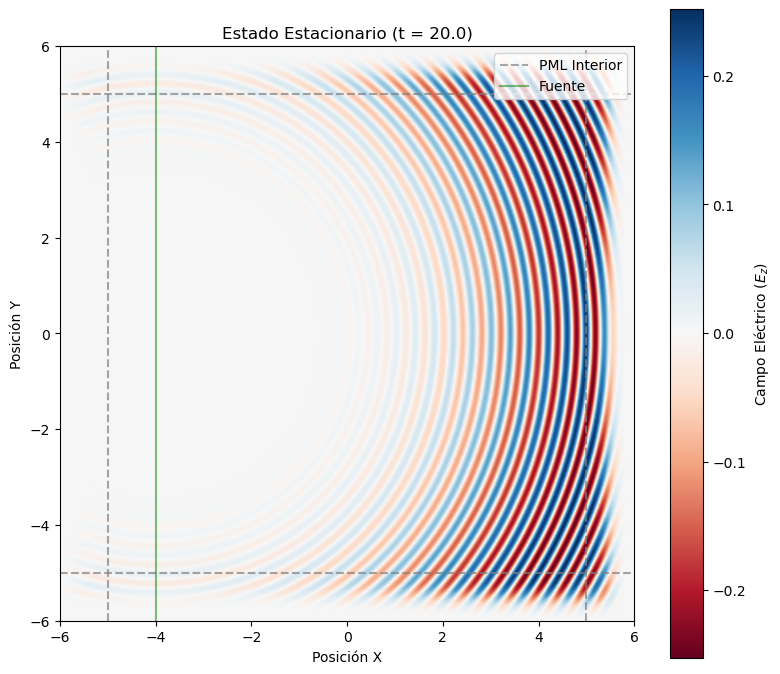


Preparando para animación...
Capturando frames cada 0.5 unidades de tiempo...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000226974 s
Working in 2D dimensions.
Computational cell is 12 x 12 x 0 with resolution 30
time for set_epsilon = 0.147652 s
-----------
run 3 finished at t = 20.0 (1200 timesteps)
Simulación completada en 1.3s
Frames capturados: 40

Creando animación...
Guardando animación como 'gaussiansource.mp4'...
Animación guardada con éxito!

Mostrando animación en notebook...


In [35]:
# Ejecutar visualización
gaussvideo = visualize_simulation(
    sim=sim,
    cell_size=cell_size,
    pml_thickness=pml_thickness,
    source_position=source_position,
    max_time=max_time,
    frame_interval=frame_interval,
    output_filename='gaussiansource.mp4'
)

# Mostrar el video en el notebook si estás en Jupyter
gaussvideo

In [50]:
gaussian_beam = mp.GaussianBeam2DSource(
    src=mp.ContinuousSource(frequency=source_frequency),
    center=mp.Vector3(0, 0),
    size=mp.Vector3(0, 0), 
    beam_x0=beam_x0,
    waist=waist,
    kdir=kdir,
    component=mp.Ez,
)


TypeError: Source.__init__() got an unexpected keyword argument 'waist'